In [1]:
import random
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from scipy.ndimage import gaussian_filter1d
from sklearn.model_selection import KFold, GridSearchCV

from side_info_decoding.utils import set_seed, load_data_from_pids

seed = 666
set_seed(seed)

### Functionality

In [2]:
def time_bin_wise_metrics(y_true, y_pred):
    r2 = r2_score(y_true.flatten(), y_pred.flatten())
    corr = pearsonr(y_true.flatten(), y_pred.flatten())[0]
    return r2, corr

def continuous_decoder(train_X, train_Y, test_X, test_Y, time_independent=False, verbose=True):
    penalty = [0.001, 0.01, 1, 10, 100, 1000]
    
    train_K, test_K = len(train_X), len(test_X)
    _, C, T = train_X.shape
    if time_independent:
        train_X = np.moveaxis(train_X, 1, -1).reshape((-1, C))
        test_X = np.moveaxis(test_X, 1, -1).reshape((-1, C))
        train_Y = train_Y.reshape((-1))
        test_Y = test_Y.reshape((-1))
        if verbose:
            print("time-independent:")
    else:
        train_X = np.moveaxis(train_X, 1, -1).reshape((-1, T*C))
        test_X = np.moveaxis(test_X, 1, -1).reshape((-1, T*C))
        if verbose:
            print("time-dependent:")
    
    decoder = GridSearchCV(Ridge(), {"alpha": penalty})
    decoder.fit(train_X, train_Y)
    pred_Y = decoder.predict(test_X)
    test_Y = test_Y.reshape(test_K, T)
    pred_Y = pred_Y.reshape(test_K, T)
    
    if time_independent:
        r2, corr = time_bin_wise_metrics(test_Y, pred_Y)
    else:
        r2, corr = time_bin_wise_metrics(test_Y, pred_Y)
        
    if verbose:
        print(f"r2: {r2:.3f} corr: {corr:.3f}")
    
    return pred_Y, [r2, corr]

def sliding_window_over_time(data, half_window_size=3):
    
    window_size = 2*half_window_size + 1
    
    if len(data.shape) == 3:
        n_trials, n_units, n_t_bins = data.shape
        data_window = np.zeros((
            n_trials, n_units, n_t_bins - 2*half_window_size, window_size
        ))
        for t in range(n_t_bins - 2*half_window_size):
            tmp_window = np.zeros((n_trials, n_units, window_size))
            for d in range(window_size):
                  tmp_window[:,:,d] = data[:,:,t + d]
            data_window[:,:,t] = tmp_window
    else:
        n_trials, n_t_bins = data.shape
        max_len = n_t_bins - 2*half_window_size
        data_window = np.zeros((n_trials, max_len, window_size))
        for t in range(max_len):
            data_window[:,t] = data[:,t:t+window_size]
        data_window = data_window[:,:,half_window_size]
    return data_window

def sliding_window_decoder(train_X, train_Y, test_X, test_Y, verbose=True):
    penalty = [0.001, 0.01, 1, 10, 100, 1000]
    
    train_K, C, T, L = train_X.shape
    test_K, _, _, _ = test_X.shape
    
    train_X = train_X.transpose(0,1,-1,2).reshape(train_K, C*L, T).transpose(0,-1,1).reshape((-1, C*L))
    test_X = test_X.transpose(0,1,-1,2).reshape(test_K, C*L, T).transpose(0,-1,1).reshape((-1, C*L))
    train_Y = train_Y.reshape((-1))
    test_Y = test_Y.reshape((-1))
    
    decoder = GridSearchCV(Ridge(), {"alpha": penalty})
    decoder.fit(train_X, train_Y)
    pred_Y = decoder.predict(test_X)
    test_Y = test_Y.reshape(test_K, T)
    pred_Y = pred_Y.reshape(test_K, T)
    
    r2, corr = time_bin_wise_metrics(test_Y, pred_Y)
    if verbose:
        print("sliding-window:")
        print(f"r2: {r2:.3f} corr: {corr:.3f}")
    
    return pred_Y, [r2, corr]

In [3]:
class ReducedRankRegression(torch.nn.Module):    
    def __init__(self, n_c, n_t, n_r):
        super(ReducedRankRegression, self).__init__()
        self.U = torch.nn.Parameter(torch.randn(n_c, n_r))
        self.V = torch.nn.Parameter(torch.randn(n_r, n_t))
        self.b = torch.nn.Parameter(torch.randn(1,))
        
    def forward(self, x):
        self.beta = self.U @ self.V
        out = torch.einsum("ct,kct->kt", self.beta, x)
        out += self.b
        return out
    
def train_rrr(
    X, 
    Y, 
    train,
    test,
    n_r = 10,
    learning_rate=1e-3,
    n_epochs=10000,
    ):
    
    _, n_c, n_t = X.shape
    rrr = ReducedRankRegression(n_c, n_t, n_r)
    optimizer = torch.optim.Adam(rrr.parameters(), lr=learning_rate, weight_decay=1e-3)
    criterion = torch.nn.MSELoss()
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    train_x, test_x = X[train], X[test]
    train_y, test_y = Y[train], Y[test]
    
    losses = []
    for epoch in tqdm(range(n_epochs), desc="Train RRR:"):
        optimizer.zero_grad()
        y_pred = rrr(train_x)
        loss = criterion(y_pred, train_y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return rrr, losses

### Load Data

In [4]:
neural_data = np.load("neural_data.npy", allow_pickle=True).item()
behavior_data = np.load("behavior_data.npy", allow_pickle=True).item()
print(neural_data.keys())
print(behavior_data.keys())

dict_keys(['po', 'lp', 'dg', 'ca1', 'vis'])
dict_keys(['wheel_speed', 'motion_energy', 'pupil_diameter', 'paw_speed'])


In [5]:
X, Y = neural_data["po"], behavior_data["motion_energy"]
K, C, T = X.shape
print(X.shape)
print(Y.shape)

(367, 159, 50)
(367, 50)


In [6]:
# data preprocessing
smooth_X = np.array(
    [[gaussian_filter1d(X[k, c, :], 4) for c in range(C)] for k in range(K)]
)
smooth_Y = np.array([gaussian_filter1d(Y[k, :], 4) for k in range(K)])
norm_Y = smooth_Y / smooth_Y.max() # to prevent gradient explosion

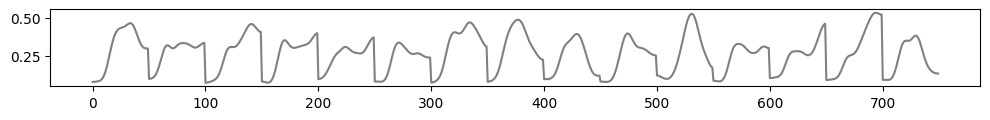

In [7]:
plt.figure(figsize=(12,1))
plt.plot(norm_Y[10:10+15].flatten(), c="gray")
plt.show()

### Find time offset for each brain region

In [8]:
kf = KFold(n_splits=5, shuffle=True, random_state=seed)

In [ ]:
# this code takes a long time to run
time_lag = {}
for l in np.arange(11):
    print(f"time lag = {l*20} ms")
    window_X = sliding_window_over_time(smooth_X, half_window_size=l)
    window_Y = sliding_window_over_time(norm_Y, half_window_size=l)
    mean_r2 = []
    for train, test in kf.split(smooth_X):
        train_X, test_X = window_X[train], window_X[test]
        train_Y, test_Y = window_Y[train], window_Y[test]
        _, metrics = sliding_window_decoder(train_X, train_Y, test_X, test_Y, verbose=False)
        mean_r2.append(metrics[0])
    print(f"5-fold CV R2 = {np.mean(mean_r2):.3f}")
    time_lag.update({l: np.mean(mean_r2)})

In [195]:
best_lag = max(time_lag, key=time_lag.get)
print(f"best time lag is {best_lag*20} ms.")

best time lag is 40 ms.


For the following analysis, use the same train and test set:

In [10]:
for train, test in kf.split(X):
    pass
print(test)

[  2   9  16  24  42  45  46  51  57  60  63  69  70  77  80  83  86  88
  91  99 100 102 103 107 112 122 126 139 141 142 147 148 151 155 156 161
 164 166 168 174 175 192 204 210 212 219 222 223 225 236 255 261 270 276
 277 282 283 290 292 294 295 301 318 322 325 328 329 333 338 342 348 355
 361]


#### Baseline

In [11]:
train_X, test_X = smooth_X[train], smooth_X[test]
train_Y, test_Y = norm_Y[train], norm_Y[test]

y_pred, _ = continuous_decoder(train_X, train_Y, test_X, test_Y, time_independent=True)
y_pred, _ = continuous_decoder(train_X, train_Y, test_X, test_Y, time_independent=False)

time-independent:
r2: 0.715 corr: 0.846
time-dependent:
r2: 0.748 corr: 0.865


In [12]:
window_X = sliding_window_over_time(smooth_X, half_window_size=best_lag)
window_Y = sliding_window_over_time(norm_Y, half_window_size=best_lag)
train_X, test_X = window_X[train], window_X[test]
train_Y, test_Y = window_Y[train], window_Y[test]
_, _ = sliding_window_decoder(train_X, train_Y, test_X, test_Y)

sliding-window:
r2: 0.723 corr: 0.850


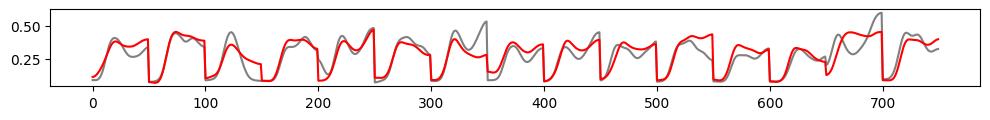

In [13]:
plt.figure(figsize=(12,1))
plt.plot(norm_Y[test][10:10+15].flatten(), c="gray")
plt.plot(y_pred[10:10+15].flatten(), c="r")
plt.show()

### Low-Rank Subspace

In [20]:
R = 10

rrr, losses = train_rrr(
    X = smooth_X,
    Y = norm_Y, 
    train = train,
    test = test,
    n_r = R,
    learning_rate = 5e-3,
    n_epochs = 10000
)

Train RRR:: 100%|█████████████████████████| 10000/10000 [03:19<00:00, 50.24it/s]


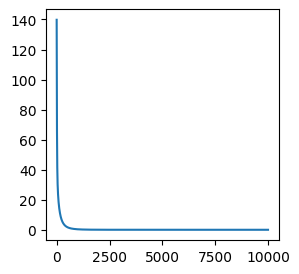

In [21]:
plt.figure(figsize=(3,3))
plt.plot(losses);

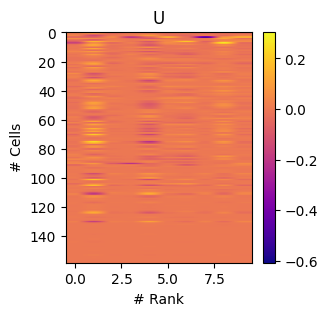

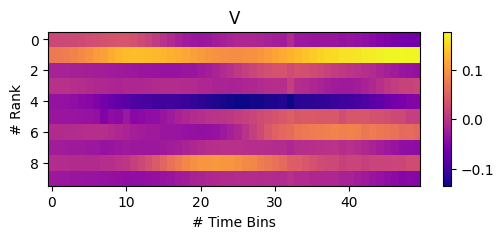

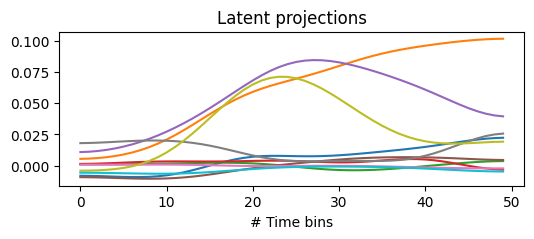

In [22]:
supervised_subspace = rrr.U.detach().numpy()
subspace_weights = rrr.V.detach().numpy()

plt.figure(figsize=(3,3))
plt.imshow(supervised_subspace, aspect="auto", cmap="plasma")
plt.title("U")
plt.xlabel("# Rank")
plt.ylabel("# Cells")
plt.colorbar()
plt.show()

plt.figure(figsize=(6,2))
plt.imshow(subspace_weights, aspect="auto", cmap="plasma")
plt.title("V")
plt.xlabel("# Time Bins")
plt.ylabel("# Rank")
plt.colorbar()
plt.show()

all_proj = smooth_X.transpose(0,-1,1) @ supervised_subspace
weighted_proj = all_proj * subspace_weights.T
smooth_proj = np.array(
    [[gaussian_filter1d(weighted_proj[k, :, r], 4) for r in range(R)] for k in range(K)]
)

plt.figure(figsize=(6,2))
plt.plot(smooth_proj.mean(0).T)
plt.title("Latent projections")
plt.xlabel("# Time bins")
plt.show()

decode with maximally demixed latents

In [23]:
train_X, test_X = smooth_proj[train], smooth_proj[test]
train_Y, test_Y = norm_Y[train], norm_Y[test]

_, _ = continuous_decoder(train_X, train_Y, test_X, test_Y, time_independent=True)
y_pred, _ = continuous_decoder(train_X, train_Y, test_X, test_Y, time_independent=False)

time-independent:
r2: 0.738 corr: 0.860
time-dependent:
r2: 0.757 corr: 0.870


In [24]:
window_X = sliding_window_over_time(smooth_proj, half_window_size=best_lag)
window_Y = sliding_window_over_time(norm_Y, half_window_size=best_lag)
train_X, test_X = window_X[train], window_X[test]
train_Y, test_Y = window_Y[train], window_Y[test]
_, _ = sliding_window_decoder(train_X, train_Y, test_X, test_Y)

sliding-window:
r2: 0.734 corr: 0.857


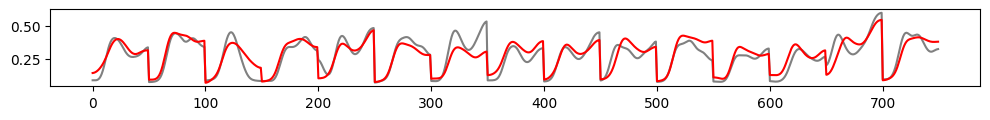

In [25]:
plt.figure(figsize=(12,1))
plt.plot(norm_Y[test][10:10+15].flatten(), c="gray")
plt.plot(y_pred[10:10+15].flatten(), c="r")
plt.show()

### PSID

In [26]:
# !pip install PSID --upgrade
import PSID
from PSID.evaluation import evalPrediction

In [27]:
xTrain = [smooth_X[k].T for k in train]
xTest = [smooth_X[k].T for k in test]
yTrain = [norm_Y[k].reshape(-1,1) for k in train]
yTest = [norm_Y[k].reshape(-1,1) for k in test]
xAll = [smooth_X[k].T for k in range(K)]

In [37]:
idSys = PSID.PSID(xTrain, yTrain, nx=20, n1=10, i=10)

In [38]:
yPred, xPred, zPred = [], [], []
for k in range(K):
    y, x, z = idSys.predict(xAll[k])
    yPred.append(y)
    xPred.append(x)
    zPred.append(z)
yPred = np.array(yPred).squeeze()
xPred = np.array(xPred)
zPred = np.array(zPred)

In [39]:
print(f"decoding R2: \
    {evalPrediction(np.concatenate(yTest), np.concatenate(yPred[test]), 'R2')[0]:.3f}"
)

decoding R2:     0.580


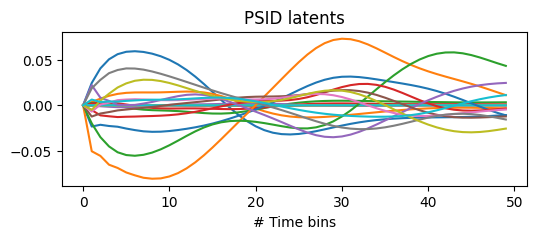

In [40]:
plt.figure(figsize=(6,2))
plt.plot(zPred.mean(0))
plt.title("PSID latents")
plt.xlabel("# Time bins")
plt.show()

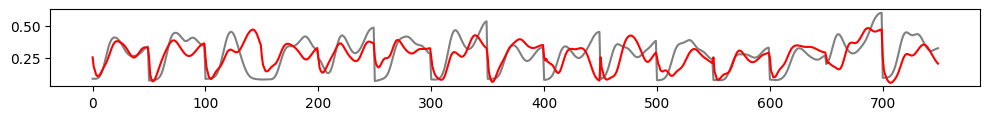

In [41]:
yTest = np.array(yTest).squeeze()
plt.figure(figsize=(12,1))
plt.plot(yTest[10:10+15].flatten(), c="gray")
plt.plot(yPred[10:10+15].flatten(), c="r")
plt.show()

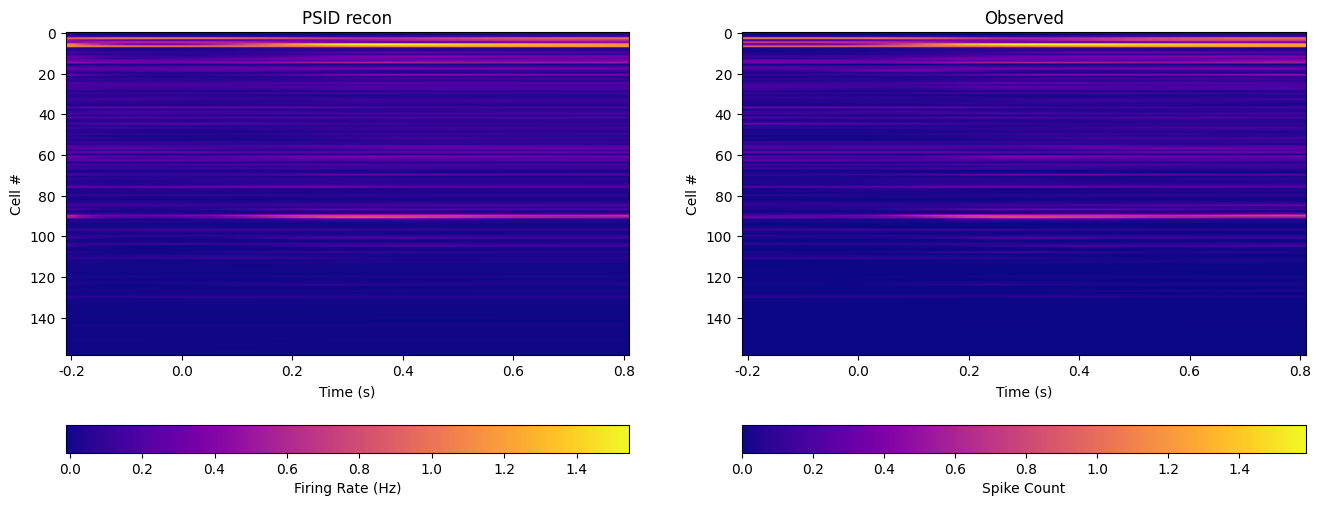

In [42]:
xTest = np.array(xTest)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6))
im1 = ax1.imshow(xPred.mean(0).T, aspect="auto", cmap=plt.cm.plasma)
ax1.set_xticks(np.linspace(0, 49, 6), ['%.1f'%i for i in np.linspace(-.2, .8, 6)])
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Cell #')
cbar = plt.colorbar(im1, ax=ax1, orientation='horizontal', label='Firing Rate (Hz)')
ax1.set_title('PSID recon')

im2 = ax2.imshow(xTest.mean(0).T, aspect="auto", cmap=plt.cm.plasma)
ax2.set_xticks(np.linspace(0, 49, 6), ['%.1f'%i for i in np.linspace(-.2, .8, 6)])
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Cell #')
cbar = plt.colorbar(im2, ax=ax2, orientation='horizontal', label='Spike Count')
ax2.set_title('Observed');

In [43]:
print(f"encoding R2: \
    {evalPrediction(np.concatenate(xTest).flatten(), np.concatenate(xPred[test]).flatten(), 'R2')[0]:.3f}"
)

encoding R2:     0.757


decode with PSID latents

In [44]:
zPred = zPred.transpose(0,-1,1)

train_X, test_X = zPred[train], zPred[test]
train_Y, test_Y = norm_Y[train], norm_Y[test]

y_pred, _ = continuous_decoder(train_X, train_Y, test_X, test_Y, time_independent=True)
y_pred, _ = continuous_decoder(train_X, train_Y, test_X, test_Y, time_independent=False)

time-independent:
r2: 0.575 corr: 0.762
time-dependent:
r2: 0.686 corr: 0.831


In [45]:
window_X = sliding_window_over_time(zPred, half_window_size=best_lag)
window_Y = sliding_window_over_time(norm_Y, half_window_size=best_lag)
train_X, test_X = window_X[train], window_X[test]
train_Y, test_Y = window_Y[train], window_Y[test]
_, _ = sliding_window_decoder(train_X, train_Y, test_X, test_Y)

sliding-window:
r2: 0.675 corr: 0.825


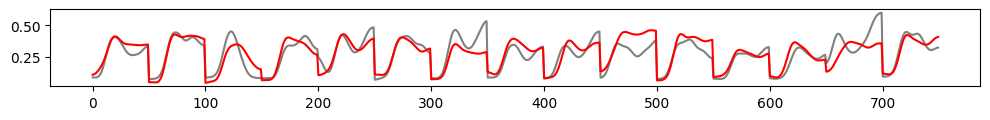

In [46]:
plt.figure(figsize=(12,1))
plt.plot(norm_Y[test][10:10+15].flatten(), c="gray")
plt.plot(y_pred[10:10+15].flatten(), c="r")
plt.show()

decode with PSID reconstructed firing rates

In [47]:
xPred = xPred.transpose(0,-1,1)

train_X, test_X = xPred[train], xPred[test]
train_Y, test_Y = norm_Y[train], norm_Y[test]

y_pred, _ = continuous_decoder(train_X, train_Y, test_X, test_Y, time_independent=True)
y_pred, _ = continuous_decoder(train_X, train_Y, test_X, test_Y, time_independent=False)

time-independent:
r2: 0.579 corr: 0.765
time-dependent:
r2: 0.736 corr: 0.858


In [48]:
window_X = sliding_window_over_time(xPred, half_window_size=best_lag)
window_Y = sliding_window_over_time(norm_Y, half_window_size=best_lag)
train_X, test_X = window_X[train], window_X[test]
train_Y, test_Y = window_Y[train], window_Y[test]
_, _ = sliding_window_decoder(train_X, train_Y, test_X, test_Y)

sliding-window:
r2: 0.677 corr: 0.827


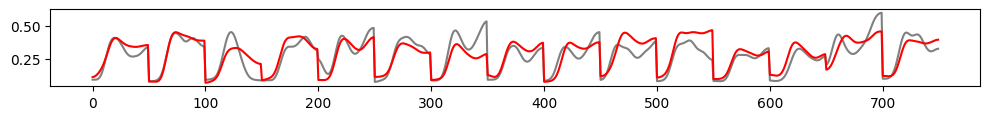

In [49]:
plt.figure(figsize=(12,1))
plt.plot(norm_Y[test][10:10+15].flatten(), c="gray")
plt.plot(y_pred[10:10+15].flatten(), c="r")
plt.show()

### LFADS

In [50]:
%cd /home/yizi/side_info_decoding/side_info_decoding/lfads/

/home/yizi/side_info_decoding/side_info_decoding/lfads


In [51]:
from lfads import LFADS_Net
device = 'cuda' if torch.cuda.is_available() else 'cpu'; print('Using device: %s'%device)

/home/yizi/anaconda3/envs/clusterless/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/yizi/anaconda3/envs/clusterless/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN3c106detail19maybe_wrap_dim_slowEllb
  warn(f"Failed to load image Python extension: {e}")


Using device: cuda


In [52]:
lfads_X = smooth_X.transpose(0,-1,1)
X_train, X_test, Y_train, Y_test = lfads_X[train], lfads_X[test], norm_Y[train], norm_Y[test]

In [53]:
all_data = torch.Tensor(lfads_X).to(device)
train_data = torch.Tensor(X_train).to(device)
valid_data = torch.Tensor(X_test).to(device)

train_ds      = torch.utils.data.TensorDataset(train_data)
valid_ds      = torch.utils.data.TensorDataset(valid_data)

In [57]:
# hyperparams in autoLFADS paper

hyperparams = {'betas': (0.9, 0.99),
 'c_encoder_dim': 80,
 'clip_val': 5.0,
 'controller_dim': 80,
 'dataset_name': 'chaotic_rnn',
 'epsilon': 0.1,
 'factors_dim': 40,
 'g0_encoder_dim': 100,
 'g0_prior_kappa': 1e-2,
 'g_dim': 100,
 'keep_prob': 0.95,
 'kl_weight_schedule_dur': 0.8,
 'kl_weight_schedule_start': 0,
 'l2_con_scale': 0,
 'l2_gen_scale': 10000, 
 'l2_weight_schedule_dur': 0.8,
 'l2_weight_schedule_start': 0,
 'learning_rate': 0.01,
 'learning_rate_decay': 0.95,
 'learning_rate_min': 1e-05,
 'max_norm': 200,
 'run_name': 'demo',
 'scheduler_cooldown': 6,
 'scheduler_on': True,
 'scheduler_patience': 6,
 'u_dim': 4,
 'u_prior_kappa': 0.1}

In [58]:
# dt = 0.02 s
model = LFADS_Net(inputs_dim = C, T = T, dt = 0.02, device=device,
                 model_hyperparams=hyperparams).to(device)

Random seed: 7952


In [59]:
# stable performance after 200 epochs
model.fit(train_ds, valid_ds, max_epochs=200, batch_size=32, use_tensorboard=False,
          train_truth=None, valid_truth=None)

Beginning training...
Epoch:    1, Step:    10, training loss: 4355.242, validation loss: 2403.785
Epoch:    2, Step:    20, training loss: 2343.298, validation loss: 2097.996
Epoch:    3, Step:    30, training loss: 2108.872, validation loss: 1917.097
Epoch:    4, Step:    40, training loss: 1970.470, validation loss: 1856.599
Epoch:    5, Step:    50, training loss: 1911.484, validation loss: 1842.550
Epoch:    6, Step:    60, training loss: 1912.387, validation loss: 1822.306
Epoch:    7, Step:    70, training loss: 1862.547, validation loss: 1812.638
Epoch:    8, Step:    80, training loss: 1853.988, validation loss: 1819.264
Epoch:    9, Step:    90, training loss: 1848.336, validation loss: 1801.472
Epoch:   10, Step:   100, training loss: 1840.856, validation loss: 1798.500
Epoch:   11, Step:   110, training loss: 1807.319, validation loss: 1789.301
Epoch:   12, Step:   120, training loss: 1820.740, validation loss: 1782.556
Epoch:   13, Step:   130, training loss: 1817.112, val

In [60]:
model.load_checkpoint('best')

In [61]:
with torch.no_grad():
    inferred_rates = np.array([model.reconstruct(all_data[i][None,:]) for i in range(K)])
    inferred_factors = np.array([model.infer_factors(all_data[i][None,:]).numpy() for i in range(K)]).squeeze()

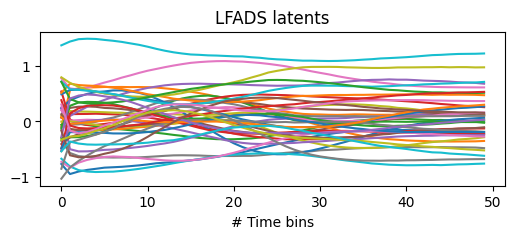

In [62]:
plt.figure(figsize=(6,2))
plt.plot(inferred_factors.mean(0))
plt.title("LFADS latents")
plt.xlabel("# Time bins")
plt.show()

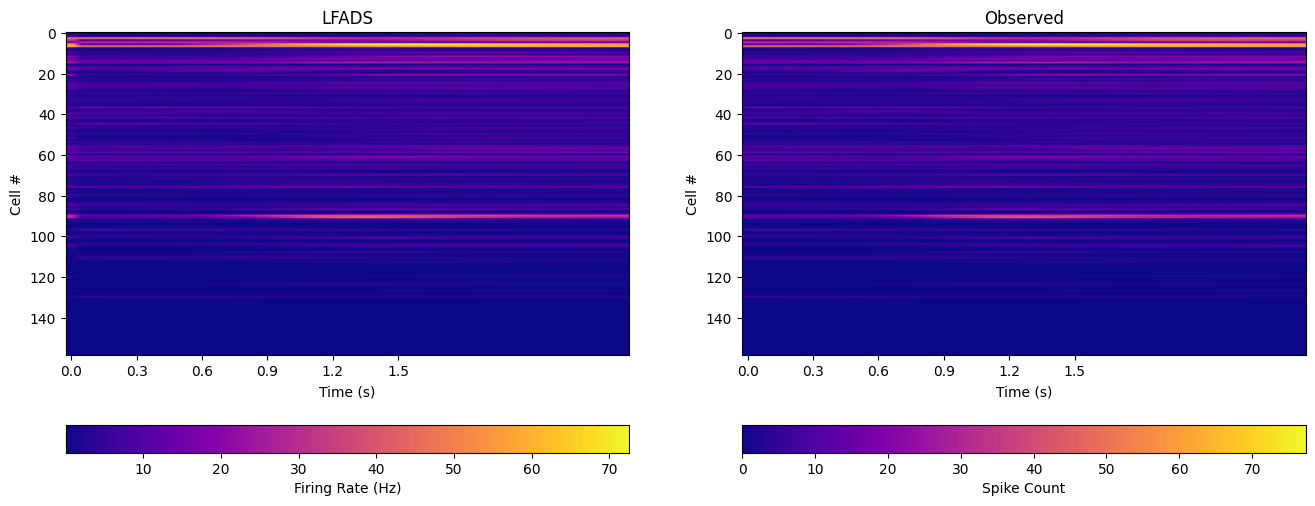

In [63]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6))
im1 = ax1.imshow(inferred_rates.mean(0).T, aspect="auto", cmap=plt.cm.plasma)
ax1.set_xticks(np.linspace(0, 29, 6), ['%.1f'%i for i in np.linspace(0, 1.5, 6)])
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Cell #')
cbar = plt.colorbar(im1, ax=ax1, orientation='horizontal', label='Firing Rate (Hz)')
ax1.set_title('LFADS')

im2 = ax2.imshow(all_data.cpu().mean(0).T/0.02, aspect="auto", cmap=plt.cm.plasma)
ax2.set_xticks(np.linspace(0, 29, 6), ['%.1f'%i for i in np.linspace(0, 1.5, 6)])
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Cell #')
cbar = plt.colorbar(im2, ax=ax2, orientation='horizontal', label='Spike Count')
ax2.set_title('Observed');

In [64]:
print(f"encoding R2: \
    {evalPrediction(np.concatenate(inferred_rates[test]).flatten(), np.concatenate(lfads_X[test]/0.02).flatten(), 'R2')[0]:.3f}"
)

encoding R2:     0.618


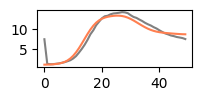

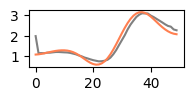

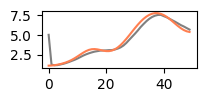

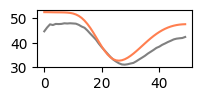

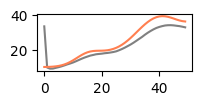

In [65]:
for unit_idx in np.arange(5):
    plt.figure(figsize=(2,.75))
    plt.plot(inferred_rates[:,:,unit_idx].mean(0), c="gray", label="LFADS")
    plt.plot(all_data.cpu()[:,:,unit_idx].mean(0)/0.02, c="coral", label="observed")
    plt.show()

In [66]:
inferred_factors = inferred_factors.transpose(0,-1,1)
train_X, test_X = inferred_factors[train], inferred_factors[test]
train_Y, test_Y = norm_Y[train], norm_Y[test]

y_pred, _ = continuous_decoder(train_X, train_Y, test_X, test_Y, time_independent=True)
y_pred, _ = continuous_decoder(train_X, train_Y, test_X, test_Y, time_independent=False)

time-independent:
r2: 0.717 corr: 0.847
time-dependent:
r2: 0.754 corr: 0.868


In [67]:
window_X = sliding_window_over_time(inferred_factors, half_window_size=best_lag)
window_Y = sliding_window_over_time(norm_Y, half_window_size=best_lag)
train_X, test_X = window_X[train], window_X[test]
train_Y, test_Y = window_Y[train], window_Y[test]
_, _ = sliding_window_decoder(train_X, train_Y, test_X, test_Y)

sliding-window:
r2: 0.719 corr: 0.848


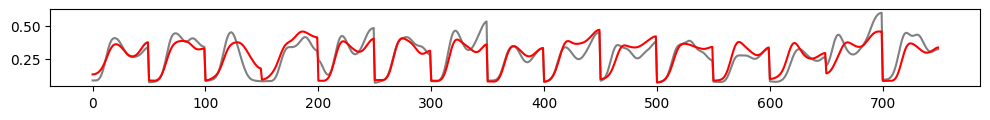

In [68]:
plt.figure(figsize=(12,1))
plt.plot(norm_Y[test][10:10+15].flatten(), c="gray")
plt.plot(y_pred[10:10+15].flatten(), c="r")
plt.show()